In [ ]:
!pip install -q easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.8 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/2023-09-22-Storiy-Images-Cropped.zip

Archive:  /content/drive/MyDrive/2023-09-22-Storiy-Images-Cropped.zip
   creating: images_cropped/
  inflating: images_cropped/cdu_22-09-2021_00:00_image3.jpeg  
  inflating: images_cropped/armin_laschet_25-09-2021_00:00_video17.jpeg  
  inflating: images_cropped/abaerbock_16-09-2021_00:00_video0.jpeg  
  inflating: images_cropped/fdp_20-09-2021_00:00_video6.jpeg  
  inflating: images_cropped/spdde_18-09-2021_00:00_image1.jpeg  
  inflating: images_cropped/afd.bund_14-09-2021_00:00_image6.jpeg  
  inflating: images_cropped/armin_laschet_17-09-2021_00:00_image10.jpeg  
  inflating: images_cropped/fw_bayern_20-09-2021_00:00_video4.jpeg  
  inflating: images_cropped/dielinke_22-09-2021_00:00_image0.jpeg  
  inflating: images_cropped/cdu_16-09-2021_00:00_video18.jpeg  
  inflating: images_cropped/christlichsozialeunion_24-09-2021_00:00_video8.jpeg  
  inflating: images_cropped/die_gruenen_25-09-2021_00:00_image4.jpeg  
  inflating: images_cropped/robert.habeck_13-09-2021_00:00_image19.jpeg

In [ ]:
!pip install replicate

In [ ]:
%env REPLICATE_API_TOKEN=840d5ec917e295d778dc2535d6aa4a851aa564f2

env: REPLICATE_API_TOKEN=840d5ec917e295d778dc2535d6aa4a851aa564f2


In [49]:
import os
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import requests
import replicate

TARGET_SIZE = (512, 512)

def merge_images_based_on_mask(original, inpainted, mask):
    """
    Blend the original and inpainted images based on the mask.
    Pixels from the inpainted image are taken where the mask is white,
    and pixels from the original image are taken where the mask is black.
    """
    if len(mask.shape) == 2:  # It means mask is single channel
        expanded_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        expanded_mask = mask

    blended = np.where(expanded_mask == 255, inpainted, original)
    return blended


def expand_bounding_box_to_capture_colorbox(img, bounding_box):
    """
    Expand the bounding box to capture nearby color boxes.
    """

    def extract_local_region_around_bbox(img, bbox, padding=40):
        """
        Extracts a local region around the bounding box with added padding.
        """
        x1, y1 = max(int(bbox[0][0]) - padding, 0), max(int(bbox[0][1]) - padding, 0)
        x2, y2 = min(int(bbox[1][0]) + padding, img.shape[1]-1), min(int(bbox[1][1]) + padding, img.shape[0]-1)
        return img[y1:y2, x1:x2], x1, y1

    def create_mask_for_color_area(region):
        """
        Create a mask for non-grayish areas within a region.
        """
        hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)
        lower_thresh = np.array([0, 40, 40])
        upper_thresh = np.array([180, 255, 255])
        return cv2.inRange(hsv, lower_thresh, upper_thresh)

    def get_largest_contour_containing_center(mask, bbox, x_offset, y_offset):
        """
        Find the largest contour which contains the center of the bounding box.
        """
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None

        center_x = int((bbox[0][0] + bbox[1][0]) / 2 - x_offset)
        center_y = int((bbox[0][1] + bbox[1][1]) / 2 - y_offset)
        largest_contour = max(contours, key=cv2.contourArea)

        for contour in contours:
            if cv2.pointPolygonTest(contour, (center_x, center_y), False) >= 0 and \
               cv2.contourArea(contour) > cv2.contourArea(largest_contour):
                largest_contour = contour

        return largest_contour

    region, x_offset, y_offset = extract_local_region_around_bbox(img, bounding_box)
    mask = create_mask_for_color_area(region)
    contour = get_largest_contour_containing_center(mask, bounding_box, x_offset, y_offset)

    if contour is None:
        return bounding_box

    x, y, w, h = cv2.boundingRect(contour)
    updated_bbox = [(int(x + x_offset), int(y + y_offset)), (int(x + w + x_offset), int(y + h + y_offset))]

    final_bbox = [
        (min(bounding_box[0][0], updated_bbox[0][0]), min(bounding_box[0][1], updated_bbox[0][1])),
        (max(bounding_box[1][0], updated_bbox[1][0]), max(bounding_box[1][1], updated_bbox[1][1]))
    ]

    width = int(final_bbox[1][0] - final_bbox[0][0])
    height = int(final_bbox[1][1] - final_bbox[0][1])
    margin_x = int(0.05 * width)
    margin_y = int(0.05 * height)

    final_bbox[0] = (int(max(final_bbox[0][0] - margin_x, 0)), int(max(final_bbox[0][1] - margin_y, 0)))
    final_bbox[1] = (int(min(final_bbox[1][0] + margin_x, img.shape[1])), int(min(final_bbox[1][1] + margin_y, img.shape[0])))

    return final_bbox


def are_boxes_close(box1, box2, threshold=100): # threshold can be adjusted
    _, y1_top = box1[0]
    _, y2_bottom = box1[1]

    _, y1_comp = box2[0]
    _, y2_comp = box2[1]

    # Check if boxes have overlapping or close y coordinates
    return (y1_comp <= y2_bottom + threshold and y1_comp >= y1_top - threshold) or \
           (y2_comp <= y2_bottom + threshold and y2_comp >= y1_top - threshold)


def merge_close_boxes(boxes, img_shape, edge_threshold=50):
    """
    Merge boxes that are close to each other.
    """
    merged_boxes = []
    while boxes:
        primary_box = boxes.pop(0)
        merged_box = list(primary_box)
        to_merge = []

        for other_box in boxes:
            if are_boxes_close(primary_box, other_box):
                to_merge.append(other_box)

                # Update the merged box dimensions
                merged_box[0] = min(merged_box[0], other_box[0])
                merged_box[1] = min(merged_box[1], other_box[1])
                merged_box[2] = max(merged_box[2], other_box[2])
                merged_box[3] = max(merged_box[3], other_box[3])

        # Remove boxes that we're going to merge from the main list
        for box in to_merge:
            boxes.remove(box)

        # Expand the merged box to the image edge if close
        if merged_box[0] <= edge_threshold:
            merged_box[0] = 0
        if merged_box[1] <= edge_threshold:
            merged_box[1] = 0
        if img_shape[1] - merged_box[2] <= edge_threshold:
            merged_box[2] = img_shape[1]
        if img_shape[0] - merged_box[3] <= edge_threshold:
            merged_box[3] = img_shape[0]

        merged_boxes.append(tuple(merged_box))

    return merged_boxes



def create_text_mask(img_path, reader):
    img = cv2.imread(img_path)
    results = reader.readtext(img_path)

    confidence_threshold = 0.9
    #results = [result for result in results if result[1] > confidence_threshold]


    mask = np.zeros_like(img)  # Initialize a black mask

    if not results:
        return None

    # Extract and expand bounding boxes
    bounding_boxes = [expand_bounding_box_to_capture_colorbox(img, detection[0]) for detection in results]

    # Merge close bounding boxes
    merged_boxes = []
    processed = [False] * len(bounding_boxes)

    for i, box in enumerate(bounding_boxes):
        if not processed[i]:
            combined_box = list(box)
            for j, other_box in enumerate(bounding_boxes[i+1:], start=i+1):
                if are_boxes_close(box, other_box):
                    processed[j] = True
                    combined_box[0] = (min(combined_box[0][0], other_box[0][0]), min(combined_box[0][1], other_box[0][1]))
                    combined_box[1] = (max(combined_box[1][0], other_box[1][0]), max(combined_box[1][1], other_box[1][1]))
            merged_boxes.append(combined_box)

    # Draw the merged bounding boxes on the mask
    for box in merged_boxes:
        top_left = box[0]
        bottom_right = box[1]
        # Create a white rectangle on the mask
        cv2.rectangle(mask, top_left, bottom_right, (255, 255, 255), -1)

    return mask



def display_images(original, mask, edited=None):
    ''' Display images using matplotlib '''
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB before plotting
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    if edited is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(edited, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB before plotting
        plt.title("Edited Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def resize_with_aspect_ratio(image, target_size, fill_color=(0, 0, 0)):
    """
    Resize an image to fit within a target size while maintaining its aspect ratio.
    Image is centered and padded to fit the target size.
    """
    ih, iw = image.shape[:2]
    th, tw = target_size

    # Calculate new width and height while keeping aspect ratio
    aspect = iw / ih
    new_width, new_height = tw, int(tw / aspect)
    if new_height > th:
        new_width, new_height = int(th * aspect), th

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Get the start x, y coordinates for centering the image
    startx = (tw - new_width) // 2
    starty = (th - new_height) // 2

    # Create a blank canvas of target size
    canvas = np.full((th, tw, 3), fill_color, dtype=np.uint8)
    canvas[starty:starty+new_height, startx:startx+new_width] = resized_image

    return canvas




def process_single_image(img_path, reader):
    # Create the text mask
    mask = create_text_mask(img_path, reader)

    if mask is None:
      print("No Text, Skipping")
      return

    # Save the mask temporarily for the API call
    mask_path = "temp_mask.png"
    cv2.imwrite(mask_path, mask)

    original_img = cv2.imread(img_path)
    resized_original = resize_with_aspect_ratio(original_img, TARGET_SIZE)
    resized_mask = resize_with_aspect_ratio(mask, TARGET_SIZE)

    # Save the resized mask temporarily for the API call
    mask_path = "temp_mask.png"
    cv2.imwrite(mask_path, resized_mask)

    # Display the resized original and mask images
    # display_images(resized_original, resized_mask)


    # Use Replicate API to inpaint the image
    output = replicate.run(
        "stability-ai/stable-diffusion-inpainting:c11bac58203367db93a3c552bd49a25a5418458ddffb7e90dae55780765e26d6",
        input={
            "prompt": "an image",
            "image": open(img_path, "rb"),
            "mask": open(mask_path, "rb"),
            "negative_prompt": "colourful boxes, text, social media stickers, nudity"
        }
    )

    # Download and save the resulting image
    edited_image_url = output[0]  # Assuming the model returns only one output
    edited_image_filename = "edited_image.jpg"
    # Download the image
    response = requests.get(edited_image_url, stream=True)
    response.raise_for_status()  # Raise an exception for HTTP errors
    with open(edited_image_filename, 'wb') as file:
        for chunk in response.iter_content(8192):
            file.write(chunk)

    # Now, read the downloaded image

    edited_image = cv2.imread(edited_image_filename)

    # Merge the images based on the mask
    merged_image = merge_images_based_on_mask(resized_original, edited_image, resized_mask)

    # Display the original, mask, edited, and merged images
    display_images(resized_original, resized_mask, merged_image)

    # Remove the temporary mask and edited image
    os.remove(mask_path)

    return merged_image

In [ ]:
reader = easyocr.Reader(['de'])
image = process_single_image("/content/images_cropped/abaerbock_14-09-2021_00:00_image6.jpeg", reader)

Processing images:   0%|          | 0/10 [00:00<?, ?it/s]

Processing die_gruenen_17-09-2021_00:00_video3.jpeg...


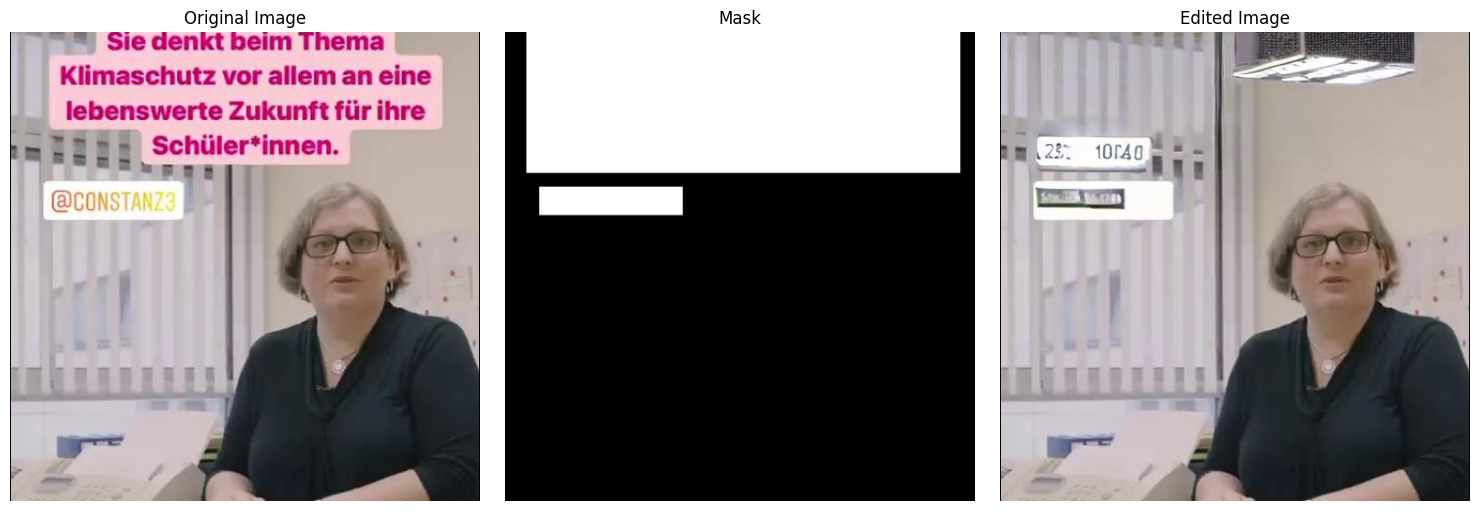

Processing images:  10%|█         | 1/10 [00:08<01:12,  8.01s/it]

Processing abaerbock_26-09-2021_00:00_video1.jpeg...


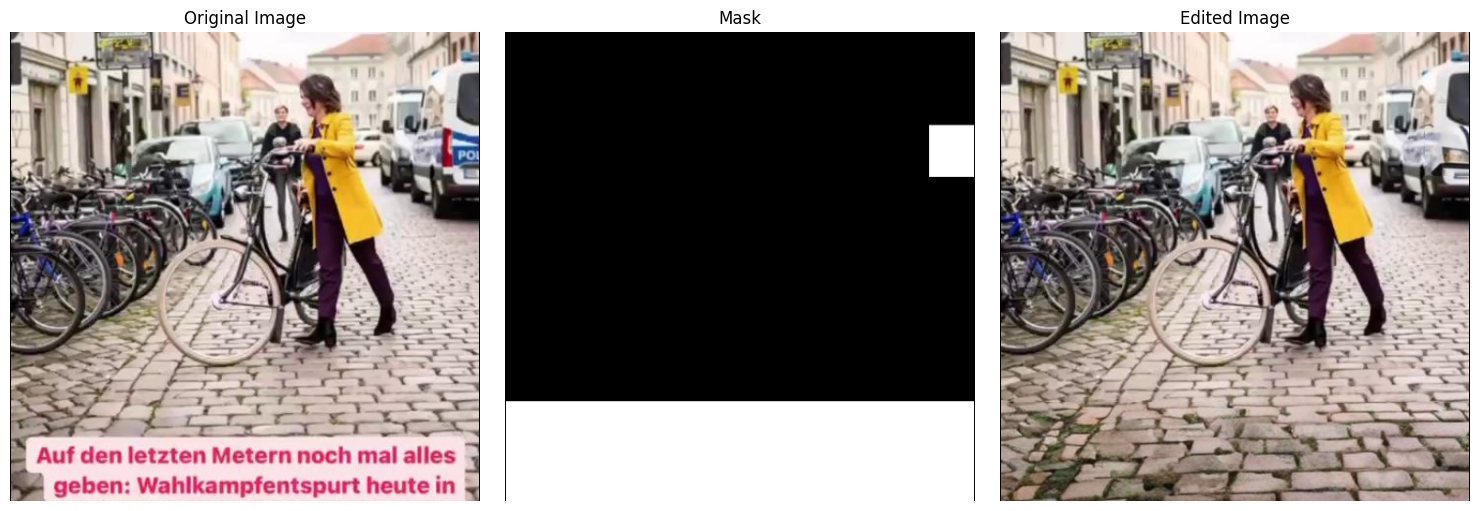

Processing images:  20%|██        | 2/10 [00:14<00:58,  7.37s/it]

Processing fdp_17-09-2021_00:00_image1.jpeg...


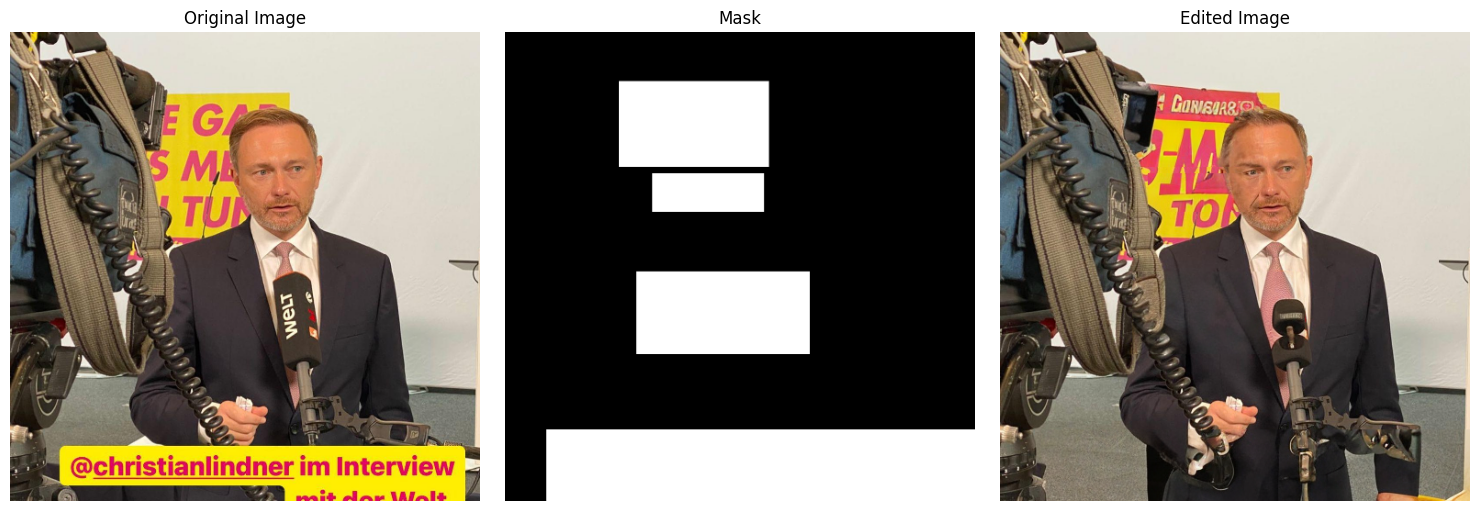

Processing images:  30%|███       | 3/10 [00:40<01:51, 15.88s/it]

Processing afd.bund_17-09-2021_00:00_video1.jpeg...


Processing images:  40%|████      | 4/10 [00:46<01:10, 11.80s/it]

Failed. Using Original.
Processing spdde_22-09-2021_00:00_video0.jpeg...


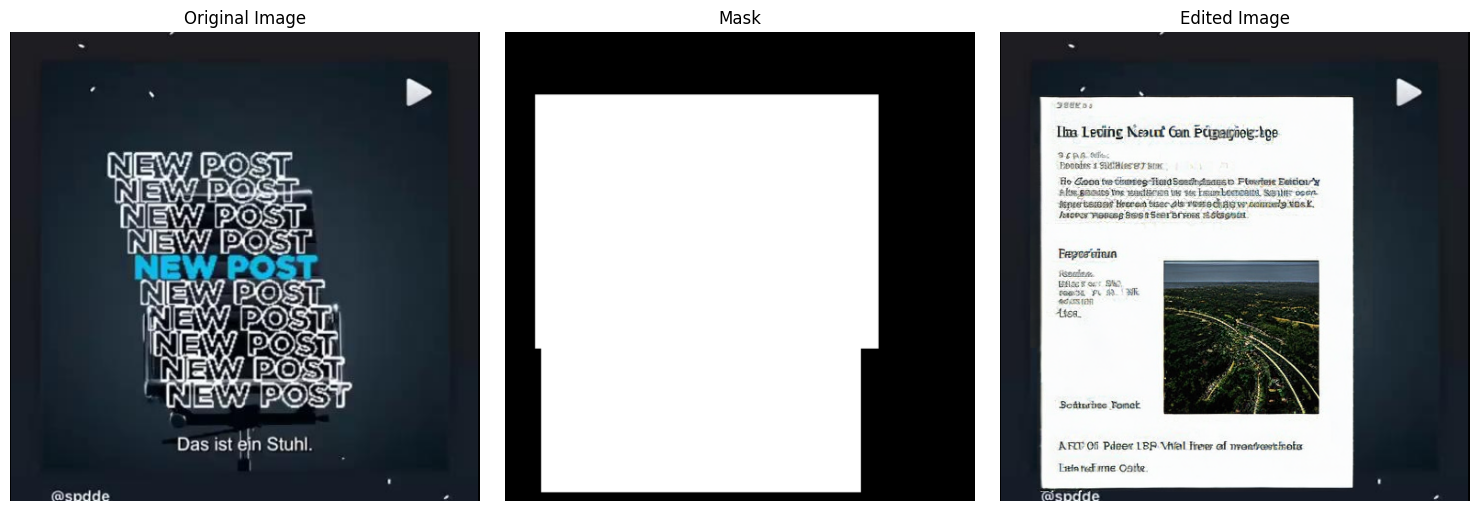

Processing images:  50%|█████     | 5/10 [00:54<00:52, 10.54s/it]

Processing afd.bund_25-09-2021_00:00_image1.jpeg...


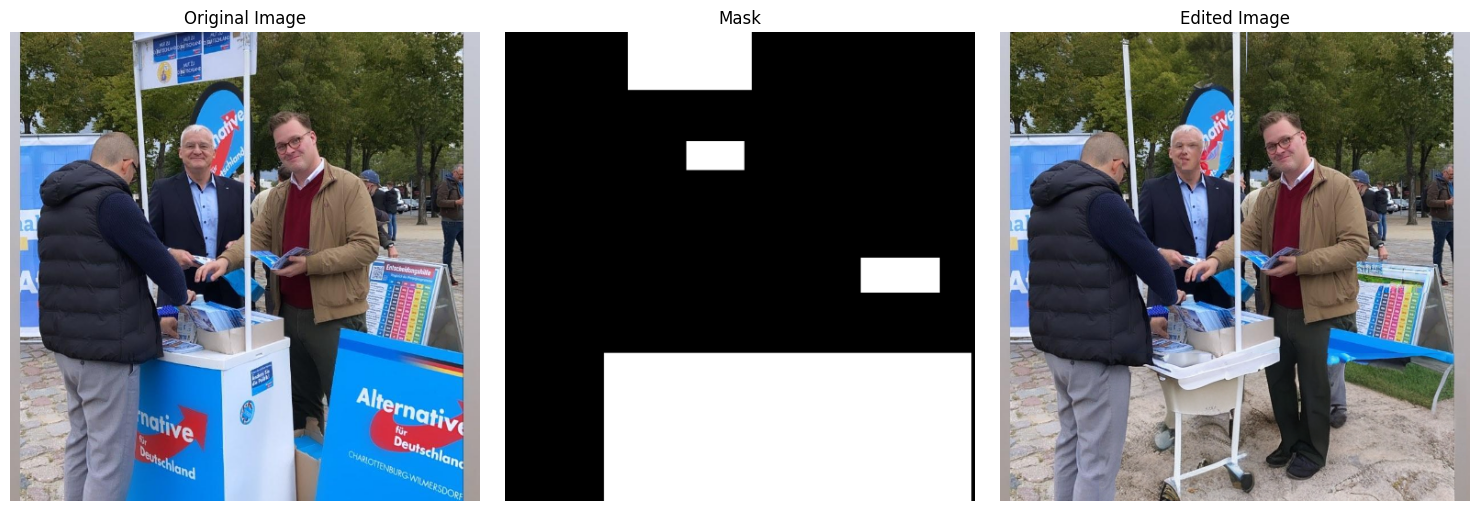

Processing images:  60%|██████    | 6/10 [01:12<00:51, 12.95s/it]

Processing armin_laschet_17-09-2021_00:00_image11.jpeg...


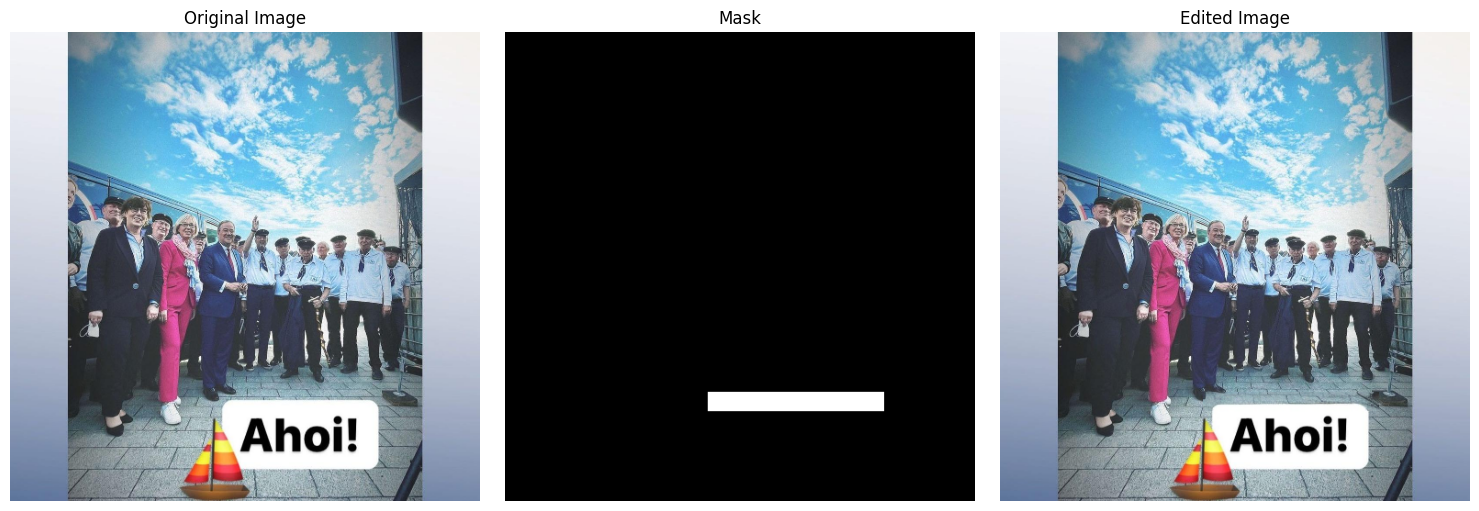

Processing images:  70%|███████   | 7/10 [01:37<00:50, 16.93s/it]

Processing abaerbock_26-09-2021_00:00_image4.jpeg...


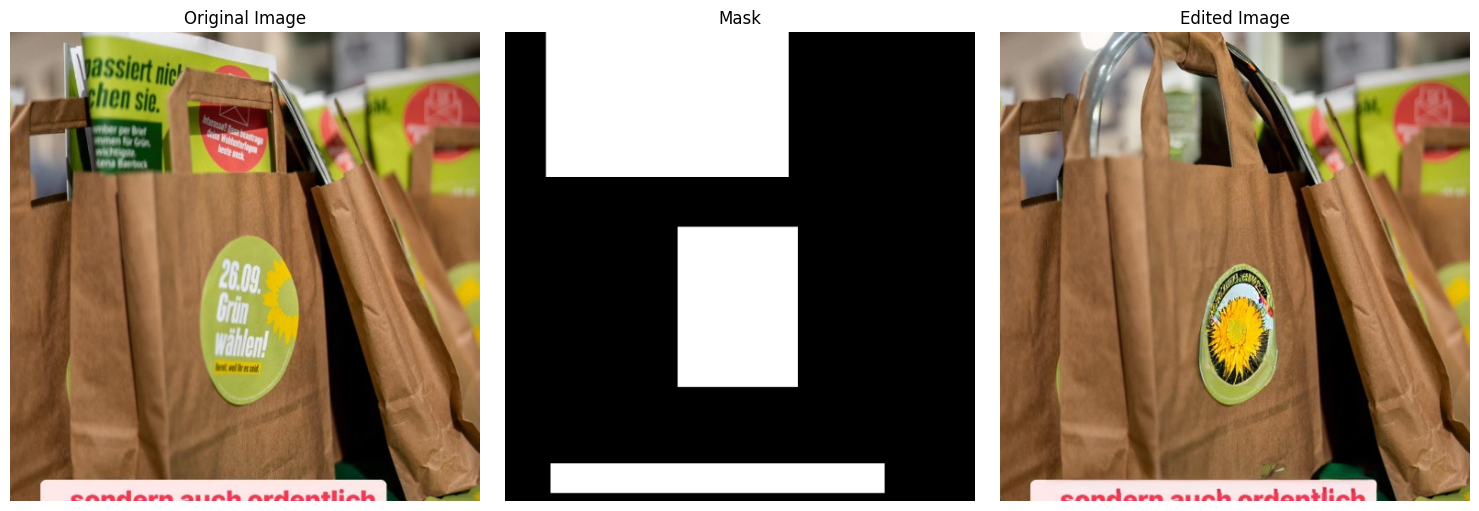

Processing images:  80%|████████  | 8/10 [01:55<00:34, 17.10s/it]

Processing markus.soeder_25-09-2021_00:00_image0.jpeg...


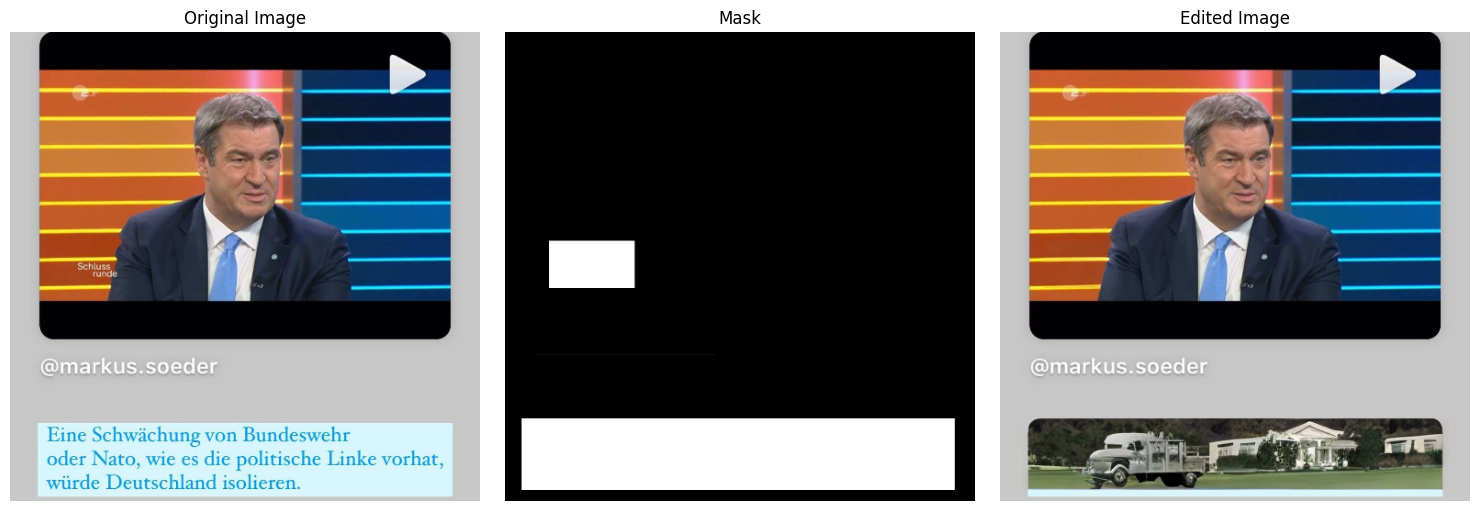

Processing images:  90%|█████████ | 9/10 [02:19<00:19, 19.52s/it]

Processing spdde_19-09-2021_00:00_video1.jpeg...


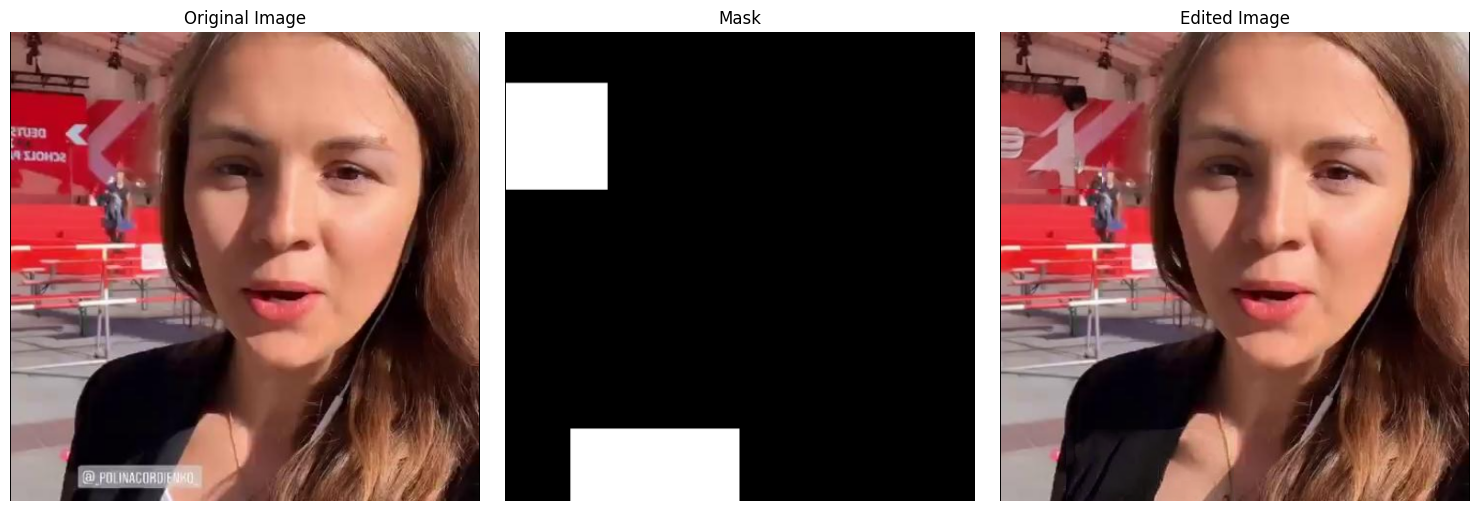

Processing images: 100%|██████████| 10/10 [02:27<00:00, 14.75s/it]


In [50]:
import os
import cv2
import easyocr
import numpy as np
from tqdm import tqdm
import random

def process_all_images(source_directory, destination_directory, reader, sample_size=None):
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    all_files = [f for f in os.listdir(source_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Sample files if needed
    if sample_size is not None:
        all_files = random.sample(all_files, sample_size)

    # Using tqdm to show progress
    for filename in tqdm(all_files, desc="Processing images"):
        print(f"Processing {filename}...")

        # Full paths to source and destination
        source_path = os.path.join(source_directory, filename)
        dest_path = os.path.join(destination_directory, filename)

        # Process the image
        try:
            processed_img = process_single_image(source_path, reader)
        except:
            processed_img = None
            print("Failed. Using Original.")

        # If no changes were made to the image or the processed_img is None,
        # save the original
        if processed_img is None or np.array_equal(processed_img, cv2.imread(source_path)):
            cv2.imwrite(dest_path, cv2.imread(source_path))
        else:
            cv2.imwrite(dest_path, processed_img)


# Initializing the reader
reader = easyocr.Reader(['de'])

# Specify the source and destination directories
src_dir = "/content/images_cropped"
dest_dir = "/content/images_cropped_wotext"

# Process all images with a sample size of, for example, 100 images
process_all_images(src_dir, dest_dir, reader, sample_size=10)

In [ ]:
!zip -r /content/drive/MyDrive/2023-09-22-Stories-Images-Cropped-wotext.zip /content/images_cropped_wotext